Ниже находятся все импорттируемые модули

In [1]:
import re
import pandas as pd
import collections


import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

Ниже расположены все созданные функции и классы

In [2]:
#Проверяет уровень благополучия города
def wellness_check(x):
    if c[x]>=3000:
        return 2
    if c[x]<3000 and c[x]>=1000:
        return 1    
    if c[x]<1000:
        return 0  

#Распределяем кухни
def cusine_checker(x):
    new_cous=set()
    for cuis in x:
        if c[cuis]>2000:
            new_cous.add(str(cuis))
        else:
            new_cous.add(str("'other'")) 
    return list(new_cous)

# вводим функцию для перевода отзывов в численное значение
def Reviews_counter (line): 
    count=0
    for word in line[0]:
        if word in good_rewiev_word:
            count+=1
        elif word in bad_rewiev_word:
            count-=1
    return(count)

# разбираем отзывы на слова. 
def Reviews_reader(line):
    line=line[2:-2]
    line=line.split('], [')
    line[0]=line[0].split(', ')
    line[1]=line[1].split(', ')
   
    for rev in line[0]:
        rev=(rev[1:-1]).lower()
        rev=rev.replace('!','')
        rev=rev.replace('.','')
        rev=rev.split(' ')
        for word in rev:
            rev_dict.add(word)
            c[word]+=1
    return(line)

Начинаем с импорта данных, и предварительного просмотра

In [3]:
df = pd.read_csv('main_task.csv')
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


видно, что некоторые значения отсутствуют (NaN), рассмотрим внимательно, в каких столбцах их больше всего

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


3 столбца Cuisine Style, Price Range, Number of Reviews имеют пропуски

# Анализ входных данных

# 'Restaurant_id'

Рассмотрим количество уникальных значений в категории и построим гистограмму распределения. Для этого избавимся от _id в названии

но насколько мы уверены, что в столбце Restauran_id все строки заполнены корректно? если восользоваться lambda функцией и replace то не ко всем знначениям может применится функция. поэтому ипортируем re и используем регулярное выражение с паттерном

In [5]:
print(df['Restaurant_id'].nunique())
df['Restaurant_id']=df['Restaurant_id'].apply(lambda x: re.sub('\D\D[_]', '', str(x)))
# и сразу переведем в численное значение
df['Restaurant_id']=pd.to_numeric(df['Restaurant_id'])
# проверим применился ли наш шаблон и какой тип значений у этого столбца
df['Restaurant_id']

11909


0        5569
1        1535
2         352
3        3456
4         615
         ... 
39995     499
39996    6340
39997    1649
39998     640
39999    4824
Name: Restaurant_id, Length: 40000, dtype: int64

<AxesSubplot:>

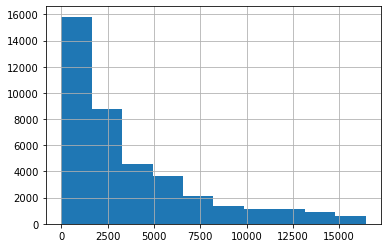

In [6]:
df['Restaurant_id'].hist()

весьма странно, что гистограма имеет подобное распределение. Обычно под ID подразумевают какой то уникальный номер  (тогда бы наша гистограмма имела бы равномерное распределение), но тут явное скопление более половины признаков в первых двух столбцах. обэтом так же свидетельствовало .nunique().
когда в начале рассмотрения этого признака - количество уникальных значенией (11909) не совпало с длиной (40к) датафрейма я подумал о дубликатах и задваивании, проверим это:

In [7]:
print(df.duplicated().unique())

[False]


Ни одного дубликата (все значения false). возможно для каждого города назначаются свои уникальные значения? Проверим это. Если соответствует действительности, то количество городов для каждого Id должно быть равно количеству уникальных городов для этого id

In [8]:
len(df[df['Restaurant_id']==df['Restaurant_id'].value_counts()[0]]['City'])==df[df['Restaurant_id']==df['Restaurant_id'].value_counts()[0]]['City'].nunique()

True

# 'City'

Рассмотрим колонку City поподробнее

In [9]:
print(df['City'].nunique())
print(df['City'].value_counts())
df['City'].describe()

31
London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64


count      40000
unique        31
top       London
freq        5757
Name: City, dtype: object

как видно из распределения значений по городам - больше всего ресторанов расположено в Лондоне, Мадриде и Париже. Как известно количество ресторанов напрямую связано с покупательской активностью и способностью населения, а ,также, обороту денежных средств в городе. 

///Офтоп
Для подтверждения можно обратить внимание на такой показатель, как количество макдональдсов в городе и уровнем жизни его граждан и размером бюджета. В Воссии рестораны этой сети почти не представлены в городах с населением менее 1 млн.чел. а количество ресторанов пропорционально растет с размером бюджета городов. В США же, где денег у населения больше, как и размер экономики  ВВП на 1 душу населения значительно выше, - Макдональдсы появляются в городах 200.000 и менее
///конец офтопа

Распределим города на 3 категории:
* более 3000 ресторанов
* от 1000 до 3000
* менее 1000 ресторанов

и назначим им соответствующие числовые категории (0-2). Наверняка этот показатель будет коррелировать с количеством дорогих ресторанох. Так же не исключаем, что жители городов с большим количеством ресторанов будут более придирчивыми, т.к. имеют больше возможностей чаще посещать подобные заведения


In [10]:
c = collections.Counter()
for city in df['City']:
    c[city]+=1
df['wellness']=df['City'].apply(wellness_check)


проверим все ли применилось:

<AxesSubplot:>

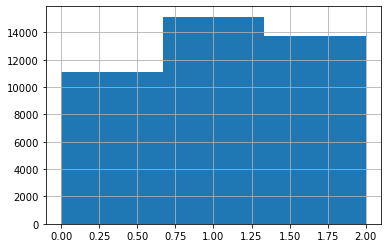

In [11]:
df['wellness'].describe()
df['wellness'].hist(bins=3)


Распределение получилось близко к равномерному, а мы сынженерили (feature engineering) еще один показатель.

# 'Cuisine Style'

Как мы помним в этом столбце у нас есть пропуски. Т.к. мы договорились не удалять строки из DF то пропуски надо будет заполнить. Но только как? для этого сначала посмотрим существующие значения и есть ли уних зависимости с другими значениями? и частоту

In [12]:

temp_df=df[df['Cuisine Style'].isna()!=True]

#переделаем текст ячеки в список
temp_df['Cuisine Style']=temp_df['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
temp_df['Cuisine Style']=temp_df['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
temp_df['Cuisine Style']=temp_df['Cuisine Style'].apply(lambda x: str(x).split(','))
temp_df['Cuisine Style']=temp_df['Cuisine Style'].values.tolist()

# И добавим столбец с количеством кухонь
temp_df['num_of_cus']=temp_df['Cuisine Style'].apply(lambda x: len(x))

<ipython-input-12-393309d2689b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Cuisine Style']=temp_df['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
<ipython-input-12-393309d2689b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Cuisine Style']=temp_df['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
<ipython-input-12-393309d2689b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Посмотри, сколько у нас есть уникальных значений кухонь?

In [13]:
temp_df['Cuisine Style'].explode('Cuisine Style').nunique()

232

Мда, многовато, надо будет перегруппировывать, посмотрим самые популярные

In [14]:
print(temp_df['Cuisine Style'].explode('Cuisine Style').value_counts().head(25))

 'Vegetarian Friendly'    10892
 'European'                7932
'Italian'                  5532
 'Vegan Options'           4473
 'Mediterranean'           4167
 'Gluten Free Options'     4107
'French'                   2844
 'Pub'                     2241
 'Pizza'                   2169
'European'                 2128
'Mediterranean'            2110
 'Asian'                   2031
 'Spanish'                 1883
'Bar'                      1801
 'Bar'                     1496
 'Central European'        1378
'Cafe'                     1351
 'British'                 1274
'Japanese'                 1190
 'International'           1066
 'Fast Food'               1063
'Chinese'                  1034
 'Portuguese'               997
'American'                  985
'Asian'                     980
Name: Cuisine Style, dtype: int64


Оставим только кухни с которые встречаются чаще 2000 раз

In [15]:
c = collections.Counter()
for cuis in temp_df['Cuisine Style'].explode('Cuisine Style'):
    c[cuis]+=1

In [16]:
temp_df['Cuisine Style']=temp_df['Cuisine Style'].apply(cusine_checker)

<ipython-input-16-7fdc0d899fbc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Cuisine Style']=temp_df['Cuisine Style'].apply(cusine_checker)


In [17]:
temp_df['Cuisine Style'].explode('Cuisine Style').value_counts()

'other'                   24791
 'Vegetarian Friendly'    10892
 'European'                7932
'Italian'                  5532
 'Vegan Options'           4473
 'Mediterranean'           4167
 'Gluten Free Options'     4107
'French'                   2844
 'Pub'                     2241
 'Pizza'                   2169
'European'                 2128
'Mediterranean'            2110
 'Asian'                   2031
Name: Cuisine Style, dtype: int64

In [18]:
temp_df[temp_df['Cuisine Style']!="'empty'"]['num_of_cus'].mean()

3.1127063189764623

как видно - среднее количество кухонь в ресторане чуть выше 3. Округлим до ближайшего верхнего числа - получается 4. следовательно с большой долей вероятности пустые строки будут содержать  следующие кухни

In [19]:
list_for_empty_cuisine=list(temp_df['Cuisine Style'].explode('Cuisine Style').value_counts()[0:4].index)
list_for_empty_cuisine

["'other'", " 'Vegetarian Friendly'", " 'European'", "'Italian'"]

Пора вернуться к основному датафрейму и заменить пустые значения кухонь на полученный список и повторить процедуры которые мы повторяли с временным датафреймлом

In [20]:
df['Cuisine Style']=df['Cuisine Style'].fillna(str(list_for_empty_cuisine))
df['Cuisine Style']=df['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
df['Cuisine Style']=df['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
df['Cuisine Style']=df['Cuisine Style'].apply(lambda x: str(x).replace('"',''))
df['Cuisine Style']=df['Cuisine Style'].apply(lambda x: str(x).replace(' ',''))
df['Cuisine Style']=df['Cuisine Style'].apply(lambda x: str(x).split(','))
df['Cuisine Style']=df['Cuisine Style'].values.tolist()

# И добавим столбец с количеством кухонь
df['num_of_cus']=df['Cuisine Style'].apply(lambda x: len(x))

In [21]:
#опустошим каунтер переопределив его заново
c = collections.Counter()
for cuis in df['Cuisine Style'].explode('Cuisine Style'):
    c[cuis]+=1

df['Cuisine Style']=df['Cuisine Style'].apply(cusine_checker)

Проверим полученный результат

In [22]:
df['Cuisine Style'].explode('Cuisine Style').value_counts()

'other'                 29209
'VegetarianFriendly'    20472
'European'              19343
'Italian'               15247
'Mediterranean'          6277
'VeganOptions'           4486
'GlutenFreeOptions'      4113
'Bar'                    3297
'French'                 3190
'Asian'                  3011
'Pizza'                  2849
'Spanish'                2798
'Pub'                    2449
'Cafe'                   2325
Name: Cuisine Style, dtype: int64

# 'Ranking'

In [23]:
df['Ranking'].describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

<AxesSubplot:>

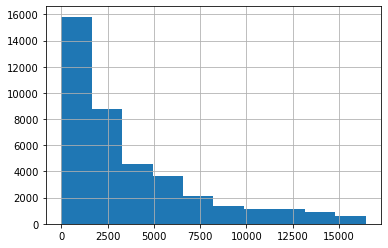

In [24]:
df['Ranking'].hist()

<AxesSubplot:>

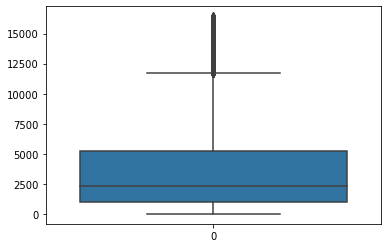

In [25]:
sns.boxplot(data=df['Ranking'])

Самое большое кpyfxtybt - 16444, хотя в среднем 3676 , а медианное значение = 2500. Избавимся от выбросов приведя их к верхнему квартилю

In [26]:
df['Ranking']=df['Ranking'].apply(lambda x: 11500 if x>=11500 else x)

<AxesSubplot:>

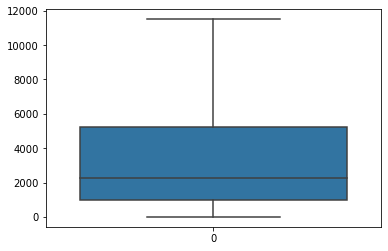

In [27]:
sns.boxplot(data=df['Ranking'])

# 'Rating'

In [28]:
print(df['Rating'].nunique())
print(df['Rating'].value_counts())
df['Rating'].describe()

9
4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64


count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

<AxesSubplot:>

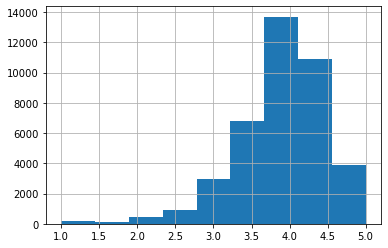

In [29]:
df['Rating'].hist(bins=9)

как видно из полученой информации - средняя оценка ресторана - 3.99, пустые значения отсутствуют. Данные не содержат выбросов.

# 'Price Range'

In [30]:
print(df['Price Range'].nunique())
print(df['Price Range'].value_counts())
df['Price Range'].describe()

3
$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64


count        26114
unique           3
top       $$ - $$$
freq         18412
Name: Price Range, dtype: object

Большая часть заведений находятся в среднем ценовом диапазоне. присвоим показателям численные значения от 0 до 2 в зависимости от стоимости

In [31]:

df['Price Range']=df['Price Range'].fillna(1)
#заменять лучше в обратном порядке, иначе полуучим артефакты ввиде 00-000 вместто 1
df['Price Range']=df['Price Range'].apply(lambda x: str(x).replace('$$$$','2'))
df['Price Range']=df['Price Range'].apply(lambda x: str(x).replace('$$ - $$$','1'))
df['Price Range']=df['Price Range'].apply(lambda x: str(x).replace('$','0'))


In [32]:
print(df['Price Range'].nunique())
print(df['Price Range'].value_counts())
df['Price Range']=pd.to_numeric(df['Price Range'])
df['Price Range'].describe()

3
1    32298
0     6279
2     1423
Name: Price Range, dtype: int64


count    40000.000000
mean         0.878600
std          0.421683
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Price Range, dtype: float64

# 'Number of Reviews'

In [33]:
df['Number of Reviews'].describe()

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

Самое большое количество отзывов - 9660, хотя в среднем на ресторан оставляют 124 отзыва, а медианное значение = 33. Возможно кто-то подкручивает отзывы. Ну или слишком популярен. построим Boxplot исразу все станет понятно


<AxesSubplot:>

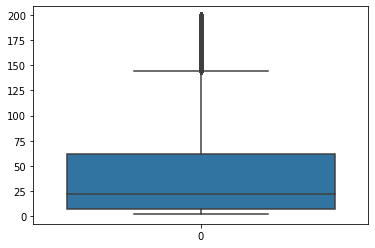

In [34]:
sns.boxplot(data=df[df['Number of Reviews']<200]['Number of Reviews'])

Заполним пропуски нулями, (можно кончно и другими данными типа среднего или медианного, возможно я попробую это после первой итерации. А может и нет) а также все выбросы приведем к 4-му квартилю

In [35]:
df['Number of Reviews']=df['Number of Reviews'].fillna(0)
df['Number of Reviews']=df['Number of Reviews'].apply(lambda x: 150 if x>=150 else x)

<AxesSubplot:>

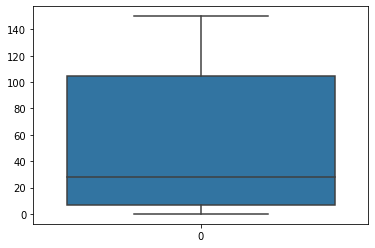

In [36]:
sns.boxplot(data=df['Number of Reviews'])

# 'Reviews'

In [37]:
#Заменяем пустые значения техническими.
df['Reviews']=df['Reviews'].replace("[[], []]", "[['no_review'], ['01/01/2000']]") 
rev_dict=set()
c = collections.Counter()


df['Reviews']=df['Reviews'].apply(Reviews_reader)
rev_dict

{'',
 'fills',
 '(ac',
 "j'burger",
 'roots',
 'negatives',
 'pizza?',
 'coffee/pastry',
 '20',
 'bavarian',
 'jovial',
 'kefta',
 'ambiguous',
 'taliano',
 'συγκινητικο',
 'roomy',
 'ealthier',
 '2,5',
 'nedible',
 'acasa',
 'heap',
 '💯',
 'parioli',
 'accepte',
 'libanaise',
 'secon',
 'competition',
 'disaster',
 '-off',
 'taps',
 'you',
 'augustiner',
 'somet',
 'deserves',
 'törökbálinti',
 'aligot',
 'barrandov',
 'disagre',
 'arrives',
 'gracious',
 'tucker',
 'by',
 'atmosphere-',
 'tortello"',
 'mislead',
 'what/how',
 'exasperating',
 'seek',
 'ff',
 'jubilee',
 'pastrie',
 'sandwiches/paninis',
 'grrek',
 'riced',
 'restaturang',
 '(sausage)',
 'skills',
 'gelatinous',
 'spanish/catalan',
 'styl',
 'pride',
 'pre-match',
 'glyfada',
 '(du',
 'astonishing',
 "'different'",
 'carte',
 'food:)',
 'food,spacious',
 'bond',
 'secluded',
 'muffins',
 'arshad',
 'centrum',
 'sempre',
 'golf',
 'vins',
 'disapointment',
 'alright;',
 'phone',
 'plaça',
 '75',
 'breakfa',
 ':-d',
 'j

In [38]:
c.most_common()

[('food', 8664),
 ('good', 8560),
 ('great', 7881),
 ('and', 7697),
 ('a', 6598),
 ('no_review', 6471),
 ('in', 4895),
 ('the', 4868),
 ('nice', 4233),
 ('place', 3881),
 ('for', 3840),
 ('very', 3173),
 ('service', 2954),
 ('restaurant', 2731),
 ('best', 2699),
 ('excellent', 2418),
 ('to', 2293),
 ('of', 2189),
 ('lunch', 2053),
 ('with', 1999),
 ('foo', 1609),
 ('delicious', 1584),
 ('but', 1538),
 ('not', 1521),
 ('pizza', 1351),
 ('lovely', 1330),
 ('amazing', 1296),
 ('dinner', 1232),
 ('tasty', 1180),
 ('friendly', 1173),
 ('-', 1083),
 ('italian', 1054),
 ('little', 1021),
 ('at', 971),
 ('bar', 940),
 ('meal', 917),
 ('atmosphere', 901),
 ('', 871),
 ('experience', 858),
 ('breakfast', 851),
 ('staff', 826),
 ('local', 818),
 ('it', 816),
 ('is', 782),
 ('value', 768),
 ('fantastic', 717),
 ('coffee', 711),
 ('on', 702),
 ('authentic', 700),
 ('you', 693),
 ('ood', 690),
 ('price', 680),
 ('perfect', 674),
 ('&', 673),
 ('quick', 663),
 ('average', 643),
 ('i', 636),
 ('wonder

In [39]:
good_rewiev_word=['good',
                  'great',
                  'best',
                  'best',
                  'excellent',
                  'delicious',
                  'amazing',
                  'lovely',
                  'brilliant',
                  'fantastic',
                  'tasty',
                  'friendly',
                  'quick',
                  'beautifulwonderful',
                  'fabulous',
                  'cool',
                 'gusto','nya','bellisimo','dequate','pleasantly','wunderfull','delucious','excellient','picturesque','👍👍','good','great','best','excellent','nice','delicious','lovely','tasty','amazing','fantastic','perfect','wonderful','pleasant','cozy','awesome','yummy','fabulous','cool','fine','brilliant','enjoyable','good!','outstanding','delicious!','charming','affordable','delightful','comfortable', '+','gorgeous','👏👏👏👏👏']

In [40]:
bad_rewiev_word=['but',
                  'worth',
                  'better',
                  'expensive',
                  'prices',
                  'poor',
                  'worst',
                  'disappointing',
                  'terrible',
                  "don't",
                  'late',
                  'nothing',
                  'slow',
                  'avoid',
                  'overpriced',
                  'rude'
                  'awful',
                  'horrible',
                'weak','only?','grubby','awseome','wash','ameri','weakest','filthy','disasterous','becareful','miserable','foo','bad','poor','stop','worst','disappointing','terrible','overpriced','rude','disappointed','horrible','mediocre','unfriendly','worse','dirty','disappointment','fo','waste','satisfying']

In [42]:
df['Reviews']=df['Reviews'].apply(Reviews_counter)


In [43]:
df['Reviews'].describe()


count    40000.000000
mean         0.001725
std          0.047666
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Reviews, dtype: float64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  int64  
 1   City               40000 non-null  object 
 2   Cuisine Style      40000 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        40000 non-null  int64  
 6   Number of Reviews  40000 non-null  float64
 7   Reviews            40000 non-null  int64  
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
 10  wellness           40000 non-null  int64  
 11  num_of_cus         40000 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.7+ MB


<AxesSubplot:>

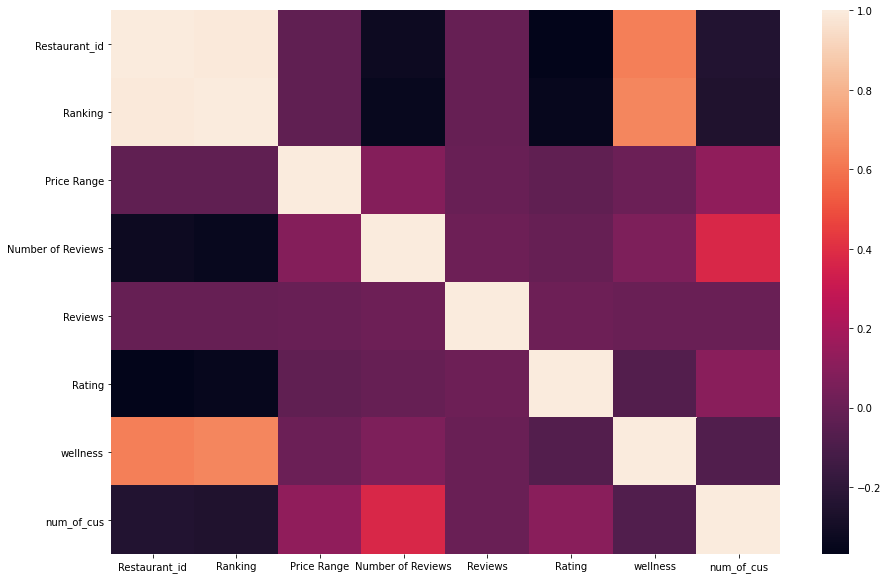

In [45]:
plt.rcParams['figure.figsize'] = (15,10)
data_samp=df[['Restaurant_id','Cuisine Style','Ranking','Price Range','Number of Reviews','Reviews','Rating','wellness','num_of_cus']]
sns.heatmap(data_samp.corr())

In [76]:

df_output=df
dummi_cuisine=pd.get_dummies(df_output['Cuisine Style'].apply(pd.Series).stack()).sum(level=0) # Создаём сет dummie-переменных
df_output=pd.concat([df_output,dummi_cuisine], axis=1) # Соединяем с сетом 
df_output=df_output.drop(['Restaurant_id', 'Cuisine Style', 'URL_TA', 'ID_TA','City'], axis = 1)


In [77]:
drop_list=[#'Ranking',
          #'Rating',
           'Price Range',
           #'Number of Reviews',
           'Reviews',
            #'wellness',
           #'num_of_cus'
          ]
print(drop_list)
df_output=df_output.drop(drop_list, axis = 1)
df_output


['Price Range', 'Reviews']


,Ranking,Rating,Number of Reviews,wellness,num_of_cus,'Asian','Bar','Cafe','European','French','GlutenFreeOptions','Italian','Mediterranean','Pizza','Pub','Spanish','VeganOptions','VegetarianFriendly','other'
0,5570.0,3.5,150.0,2,3,0,0,0,1,1,0,0,0,0,0,0,0,0,1
1,1537.0,4.0,10.0,0,4,0,0,0,1,0,0,1,0,0,0,0,0,1,1
2,353.0,4.5,150.0,2,7,1,0,0,0,0,1,0,0,0,0,0,1,1,1
3,3458.0,5.0,3.0,1,4,0,0,0,1,0,0,1,0,0,0,0,0,1,1
4,621.0,4.0,84.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,79.0,1,4,0,0,0,0,0,1,1,0,0,0,0,1,1,0
39996,6341.0,3.5,150.0,2,5,0,1,0,1,1,0,0,0,0,0,0,0,1,1
39997,1652.0,4.5,4.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39998,641.0,4.0,70.0,0,5,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [78]:
X = df_output.drop(['Rating'], axis = 1)
y = df_output['Rating']

In [79]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [80]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [81]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.34442431326633915


<AxesSubplot:>

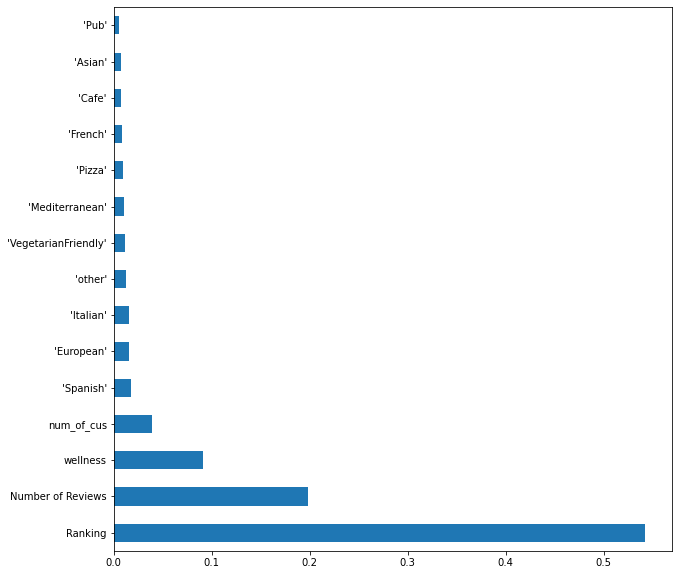

In [82]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Выводы.

Полученный MAE=0.34, что на 0.08 меньше чем полученный при первой тренировке (тогда MAE составил 0.42).
Отсюда можно предположить, что обработанная модель показывает более высокие результаты в точности предсказания рейтинга ресторана. При этом в модели есть потенциал для роста и доработки.

Новые признаки (feature Engineering) показали высокую степень влияния на модели, что так же жоказывает полезность проведенной работы
